<a href="https://colab.research.google.com/github/buthaina279/LSTM_MIMIC-III/blob/main/LSTM_final_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#for google drive
DATA_FILEPATH = "/content/drive/MyDrive/final_project/"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division
import numpy as np
import pandas as pd
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

##Read 

In [ ]:
import pandas as pd, numpy as np
train = pd.read_csv(DATA_FILEPATH + 'train_20.csv',index_col=0) 
validation = pd.read_csv(DATA_FILEPATH + 'validation_20.csv',index_col=0) 
test = pd.read_csv(DATA_FILEPATH + 'test_20.csv',index_col=0) 

In [ ]:
train_ids = pd.read_csv(DATA_FILEPATH + 'train_ids.csv',index_col=0) 
validation_ids = pd.read_csv(DATA_FILEPATH + 'validation_ids.csv',index_col=0) 
test_ids = pd.read_csv(DATA_FILEPATH + 'test_ids.csv',index_col=0) 

Drop IDs and keep only the icustay_id because it is needed for the next operations

In [ ]:
train.drop(['subject_id', 'hadm_id','hours_in'], axis=1, inplace=True)
print("train shape ", train.shape)
validation.drop(['subject_id', 'hadm_id','hours_in'], axis=1, inplace=True)
print("validation shape ", validation.shape)
test.drop(['subject_id', 'hadm_id','hours_in'], axis=1, inplace=True)
print("test shape ", test.shape )

train shape  (465471, 23)
validation shape  (66629, 23)
test shape  (133038, 23)


##Extract the labels

In [ ]:
def get_lables_drop(train, test, validation):
  # training labels
  group_train = train.groupby('icustay_id')
  train_goal_df = group_train.apply(lambda x: x['mort_icu'].unique())
  train_goal_df = train_goal_df.apply(pd.Series)
  print("train lables \n")
  print(train_goal_df.shape)
  #train_goal_df.head()

  # Drop the label column now that labels have been extracted
  train = train.drop(['mort_icu'],axis=1)
  print("drop train lables \n")
  print(train.shape)
  train.head()

  # validation labels
  group_validation = validation.groupby('icustay_id')
  validation_goal_df = group_validation.apply(lambda x: x['mort_icu'].unique())
  validation_goal_df = validation_goal_df.apply(pd.Series)
  print("validation lables \n")
  print(validation_goal_df.shape)
  validation_goal_df.head()

  #Drop the label column now that labels have been extracted
  validation = validation.drop(['mort_icu'],axis=1)
  print("drop validation lables \n")
  print(validation.shape)
  validation.head()

  # test labels
  group_test = test.groupby('icustay_id')
  test_goal_df = group_test.apply(lambda x: x['mort_icu'].unique())
  test_goal_df = test_goal_df.apply(pd.Series)
  print("test lables \n")
  print(test_goal_df.shape)
  #test_goal_df.head()

  # Drop the label column now that labels have been extracted
  test = test.drop(['mort_icu'],axis=1)
  print("drop test lables \n")
  print(test.shape)
  test.head()

  return train, test, validation,  train_goal_df, test_goal_df, validation_goal_df


In [ ]:
train, test, validation,  train_goal_df, test_goal_df, validation_goal_df = get_lables_drop(train, test, validation)

train lables 

(19792, 1)
drop train lables 

(465471, 22)
validation lables 

(2827, 1)
drop validation lables 

(66629, 22)
test lables 

(5656, 1)
drop test lables 

(133038, 22)


In [ ]:
y_train = train_goal_df[0]
y_validation = validation_goal_df[0]
y_test = test_goal_df[0]

y_train = np.asarray(y_train)
y_validation = np.asarray(y_validation)
y_test = np.asarray(y_test)

print(y_train.shape)
print(y_train)
print('\n')
print(y_validation.shape)
print(y_validation)
print('\n')
print(y_test.shape)
print(y_test)

(19792,)
[0 0 1 ... 0 0 0]


(2827,)
[0 0 0 ... 0 0 0]


(5656,)
[0 0 0 ... 0 0 0]


##Feature Scaling

In [ ]:
scaler_MinMaxScaler = preprocessing.MinMaxScaler()
#scaler_StandardScaler = preprocessing.StandardScaler()

# Get column names
col_names = list(train.columns.values)
print(col_names)

['icustay_id', 'los_icu', 'cmo', 'cmo_last', 'dnr', 'cmo_first', 'los_icu.1', 'max_hours', 'glucose_mean', 'dnr_first', 'admission_type_EMERGENCY', 'heart rate_mean', 'insurance_Private', 'mean blood pressure_mean', 'readmission_30', 'diastolic blood pressure_mean', 'systolic blood pressure_mean', 'admission_type_ELECTIVE', 'oxygen saturation_mean', 'first_careunit_CSRU', 'fullcode_first', 'fullcode']


In [ ]:
cols_to_norm = col_names[1:] # Columns to normalize

###################
# Fit training data on the scaler object
fitted_scaler_MinMaxScaler = scaler_MinMaxScaler.fit(train[cols_to_norm])


train[cols_to_norm] = fitted_scaler_MinMaxScaler.transform(train[cols_to_norm])
print(train.head())

# Use the scalar object fitted on training data to normalize the validation set
validation[cols_to_norm] = fitted_scaler_MinMaxScaler.transform(validation[cols_to_norm])
print(validation.head())

# Use the scalar object fitted on training data to normalize the test set
test[cols_to_norm] = fitted_scaler_MinMaxScaler.transform(test[cols_to_norm])
print(test.head())

   icustay_id   los_icu  cmo  cmo_last  dnr  cmo_first  los_icu.1  max_hours  \
0      290512  0.134513  0.0       0.0  0.0        0.0   0.134513   0.132159   
1      290512  0.134513  0.0       0.0  0.0        0.0   0.134513   0.132159   
2      290512  0.134513  0.0       0.0  0.0        0.0   0.134513   0.132159   
3      290512  0.134513  0.0       0.0  0.0        0.0   0.134513   0.132159   
4      290512  0.134513  0.0       0.0  0.0        0.0   0.134513   0.132159   

   glucose_mean  dnr_first  ...  insurance_Private  mean blood pressure_mean  \
0      0.081867        0.0  ...                0.0                  0.289557   
1      0.078806        0.0  ...                0.0                  0.205696   
2      0.078806        0.0  ...                0.0                  0.237342   
3      0.078806        0.0  ...                0.0                  0.218354   
4      0.078806        0.0  ...                0.0                  0.218354   

   readmission_30  diastolic blood pre

##Padding with zero

In [ ]:
#fill grouped train to have same length

def fill_data(df):
  df_fill = df.set_index(["icustay_id", df.groupby("icustay_id").cumcount()])
  index = pd.MultiIndex.from_product(df_fill.index.levels, names=df_fill.index.names)
  output = df_fill.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()
  return output

In [ ]:
df_fill_train = fill_data(train)
df_fill_validation = fill_data(validation)
df_fill_test = fill_data(test)

In [ ]:
train_ids = train_ids['0'].values.tolist()
validation_ids = validation_ids['0'].values.tolist()
test_ids = test_ids['0'].values.tolist()

##Reshape Dataset to 3D array

In [ ]:
nb_samples_train = len(train_ids)
nb_samples_validation = len(validation_ids)
nb_samples_test = len(test_ids)
nb_timestps = 24
nb_feat = 21 #48 #75 #36

X_train = np.zeros((nb_samples_train, nb_timestps, nb_feat)) 
X_validation = np.zeros((nb_samples_validation, nb_timestps, nb_feat)) 
X_test = np.zeros((nb_samples_test, nb_timestps, nb_feat))

# Create a mapper to map the time series IDs to indices in the 3-D array for the train and test set
TrainId_mapper = dict(zip(train_ids,range(nb_samples_train))) 
ValidationId_mapper = dict(zip(validation_ids,range(nb_samples_validation))) 
TestId_mapper = dict(zip(test_ids,range(nb_samples_test)))

grouped_train = df_fill_train.groupby('icustay_id')
grouped_validation = df_fill_validation.groupby('icustay_id')
grouped_test = df_fill_test.groupby('icustay_id')


# Fill up the entries in the train and test data 3d array
# train data
for ID in train_ids:
    grp_train = grouped_train.get_group(ID).reset_index(drop=True).drop(['icustay_id'],axis=1)
    X_train[TrainId_mapper[ID],:,:] = grp_train.values

# validation data
for ID in validation_ids:
    grp_validation = grouped_validation.get_group(ID).reset_index(drop=True).drop(['icustay_id'],axis=1)
    X_validation[ValidationId_mapper[ID],:,:] = grp_validation.values


# Test data
for ID in test_ids:
    grp_test = grouped_test.get_group(ID).reset_index(drop=True).drop(['icustay_id'],axis=1)
    X_test[TestId_mapper[ID],:,:] = grp_test.values
    
print(X_train.shape) 
print(X_train) 
print('\n')
print(X_validation.shape) 
print(X_validation) 
print('\n')
print(X_test.shape) 
print(X_test)    

(19792, 24, 21)
[[[0.13451306 0.         0.         ... 0.         1.         1.        ]
  [0.13451306 0.         0.         ... 0.         1.         1.        ]
  [0.13451306 0.         0.         ... 0.         1.         1.        ]
  ...
  [0.13451306 0.         0.         ... 0.         1.         1.        ]
  [0.13451306 0.         0.         ... 0.         1.         1.        ]
  [0.13451306 0.         0.         ... 0.         1.         1.        ]]

 [[0.52467429 0.         0.         ... 0.         1.         1.        ]
  [0.52467429 0.         0.         ... 0.         1.         1.        ]
  [0.52467429 0.         0.         ... 0.         1.         1.        ]
  ...
  [0.52467429 0.         0.         ... 0.         1.         1.        ]
  [0.52467429 0.         0.         ... 0.         1.         1.        ]
  [0.52467429 0.         0.         ... 0.         1.         1.        ]]

 [[0.03338398 0.         0.         ... 0.         1.         1.        ]
  [0.0

##Transform the target to be categorical feature with two columns

In [ ]:
from keras.utils.np_utils import to_categorical
num_classes = 2
Y_train = to_categorical(y_train, num_classes)
Y_validation = to_categorical(y_validation, num_classes)
Y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

print('\n')

print(Y_train.shape)
print(Y_validation.shape)
print(Y_test.shape)

(19792,)
(2827,)
(5656,)


(19792, 2)
(2827, 2)
(5656, 2)


##Functions

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from keras.callbacks import History

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
def plot_metric(history):
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('Model AUC ROC')
  plt.ylabel('AUC ROC')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5382648898558607, 1: 7.033404406538735}

#Experiments

In [ ]:
def get_model(trainX, trainy, units1, units2, units3, dropout):
  
    model = Sequential()

    model.add(LSTM(units1, activation = 'relu', input_shape = (nb_timestps, nb_feat))) 
    model.add(Dropout(dropout))

    model.add(Dense(units2, activation = 'relu')) 
    model.add(Dropout(dropout))

    model.add(Dense(units3, activation = 'relu')) 
    model.add(Dropout(dropout))

    model.add(Dense(units = 2, activation = 'sigmoid'))
    return model

In [ ]:
import tensorflow as tf
#by default -> monitor='val_loss' and patience=0
early_stopping = EarlyStopping()

def run_model(X_train, Y_train,X_validation, Y_validation, units1, units2, units3, batch_sz, epoch_sz, cw, dropout, learning_rate): #, units, dropout, learning_rate, batch_size, epoch
  model = get_model(X_train, Y_train, units1, units2, units3, dropout)
  model.summary()
  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss= 'binary_crossentropy',
    metrics = ["AUC"]) # the default AUC is ROC

  #verbose, epochs, batch_size = 2, epoch_sz, batch_sz  #change the batch size to 40 as Msh and 250 as Purush
  verbose = 1
  if cw == 0: 
    history = model.fit(X_train, Y_train,
          epochs=epoch_sz, 
          batch_size=batch_sz, 
          verbose=verbose, 
          validation_data = (X_validation, Y_validation),
          callbacks=[early_stopping],)
          #class_weight=class_weights)
  else:
    history = model.fit(X_train, Y_train,
          epochs=epoch_sz, 
          batch_size=batch_sz, 
          verbose=verbose, 
          validation_data = (X_validation, Y_validation),
          callbacks=[early_stopping],
          class_weight=class_weights)

  return history, model


class weight with early stopping

In [ ]:
seed = 7
tf.random.set_seed(seed)

batch_size = 40
dropout = 0.3
learning_rate = 0.01
units1 = 16
units2 = 32
units3 = 64
epoch = 25
class_weight = 1

history, model = run_model(X_train, Y_train,X_validation, Y_validation, units1,units2,units3, batch_size, epoch, class_weight, dropout, learning_rate) # learning_rate, batch_size, epoch

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                2432      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

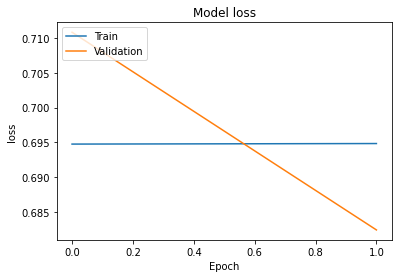

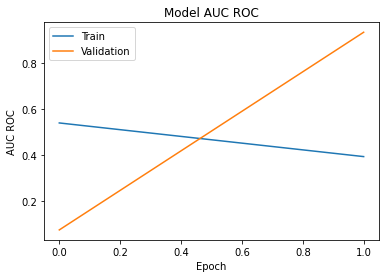

In [ ]:
plot_loss(history)
plot_metric(history)

classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5279
           1       0.00      0.00      0.00       377

    accuracy                           0.93      5656
   macro avg       0.47      0.50      0.48      5656
weighted avg       0.87      0.93      0.90      5656

AUROC 0.5
AUPRC 0.06665487977369165


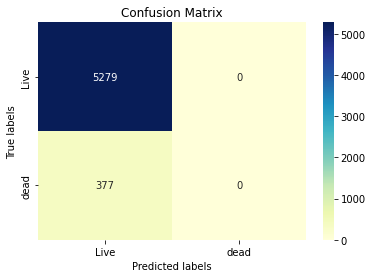

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
import seaborn as sns

final_predictions= np.argmax(model.predict(X_test),axis=1)


cm = confusion_matrix(y_test, final_predictions)
# print('confusion matrix:')
# print(cm)
# #print('\n')
print('classification report:')
print(classification_report(y_test, final_predictions))

print('===============================================================================')
print("AUROC",roc_auc_score(y_test, final_predictions))
print("AUPRC",average_precision_score(y_test, final_predictions))



ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation
  # labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Live', 'dead']); ax.yaxis.set_ticklabels(['Live', 'dead']);



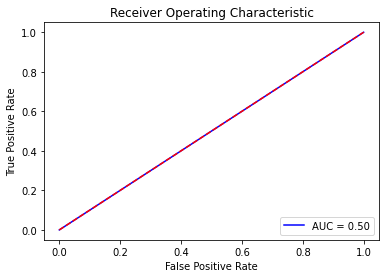

In [ ]:
buildROC(y_test, final_predictions)